In [1]:
import tensorflow as tf
from losses import binary_crossentropy 
from tensorflow.keras.utils import plot_model
from eunet import build_EUNet, get_callbacks
from loading_preprocessing_dataset import prepare_dataset, create_dataset
from loading_preprocessing_dataset import gaussian_filter, find_threshold_otsu, binary
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13338466211377080411,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5873729366235797174
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6290552928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12880918123311397499
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13378087283684516982
 physical_device_desc: "device: XLA_GPU device"]

## 1. Build Efficient U-Net 

In [3]:
model = build_EUNet(number_classes = 1, input_height = 256, input_width = 256)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][0]          

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0145783 to fit



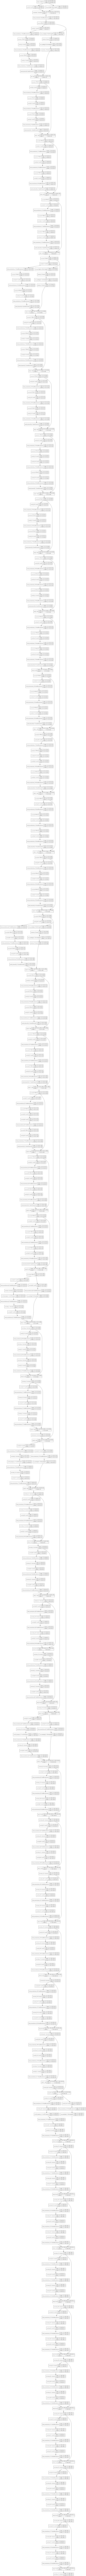

In [5]:
plot_model( model,
            to_file='model.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=4048)

In [6]:
model.compile("adam", loss=binary_crossentropy)

## 2. Load and Prepare Train, Validation and Test Datasets

In [7]:
Train_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/"
Valid_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/"
Test_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/"

In [8]:
train_sb_dir, train_gt_dir, sb_train_list, gt_train_list = prepare_dataset(Train_Dataset_dir) #load Satellite und Ground Truths Data
valid_sb_dir, valid_gt_dir, sb_valid_list, gt_valid_list = prepare_dataset(Valid_Dataset_dir)
test_sb_dir, test_gt_dir, sb_test_list, gt_test_list = prepare_dataset(Test_Dataset_dir)

Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_SB/
Number of  ground truths: 6876

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_GT/
Number der satellien images: 6876
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_SB/
Number of  ground truths: 756

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_GT/
Number der satellien images: 756
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_SB/
Number of  ground truths: 774

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_GT/
Number der satellien images: 774
*********************************************


In [9]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
number_batches = 16 #
buffer_size =  20000

In [10]:
train_dataset = create_dataset(sb_train_list, gt_train_list, buffer_size =  buffer_size, number_batche = number_batches )
validation_dataset = create_dataset(sb_valid_list, gt_valid_list, buffer_size =  buffer_size, number_batche = number_batches )
test_dataset = create_dataset(sb_test_list, gt_test_list, buffer_size =  buffer_size, number_batche = number_batches )

(16, 256, 256, 3) (16, 256, 256, 1)


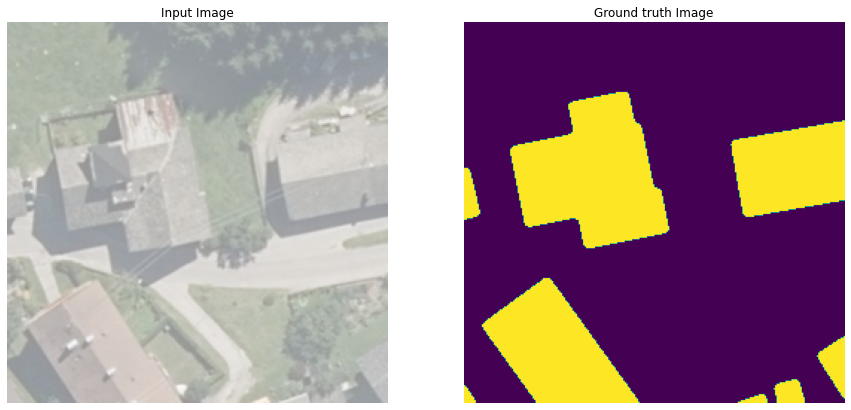

In [11]:
for SB, GT in validation_dataset.take(1):
    plt.figure(figsize=(15,15))
    print(SB.shape, GT.shape)
    display_list=[SB[0,:,:,:,],GT[0,:,:,:,]]
    title = ['Input Image', 'Ground truth Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*.5+.5 )
        plt.axis('off')
    plt.show()

## 3. Train Model

In [15]:
callbacks_list = get_callbacks()
model.fit(train_dataset,
          epochs= 100,
          verbose=1,
          callbacks=callbacks_list,
          validation_data= validation_dataset)

Epoch 1/100
430/430 [==============================] - ETA: 0s - loss: 0.8851
Epoch 00001: val_loss improved from inf to 0.59854, saving model to ./models/E_UNet_(12-30-2020 , 23:28:16)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-30-2020 , 23:28:16)/assets
430/430 [==============================] - 134s 311ms/step - loss: 0.8851 - val_loss: 0.5985
Epoch 2/100
430/430 [==============================] - ETA: 0s - loss: 0.5987
Epoch 00002: val_loss improved from 0.59854 to 0.56916, saving model to ./models/E_UNet_(12-30-2020 , 23:28:16)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-30-2020 , 23:28:16)/assets
430/430 [==============================] - 132s 308ms/step - loss: 0.5987 - val_loss: 0.5692
Epoch 3/100
430/430 [==============================] - ETA: 0s - loss: 0.5483
Epoch 00003: val_loss improved from 0.56916 to 0.47654, saving model to ./models/E_UNet_(12-30-2020 , 23:28:16)
INF

KeyboardInterrupt: 

In [46]:
model.save("./E_UNet.h5")
# load model
model = load_model("./E_UNet.h5")

## 4. Test Model

(16, 256, 256, 3) (16, 256, 256, 1)


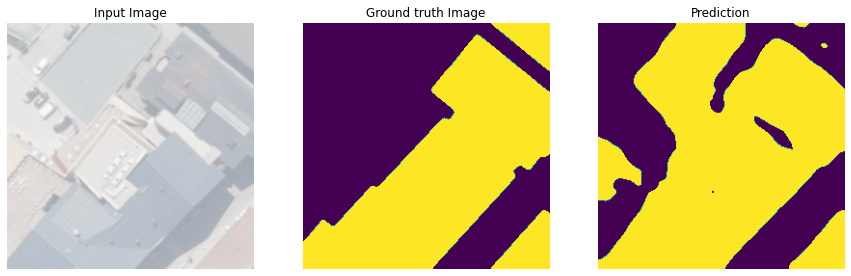

(16, 256, 256, 3) (16, 256, 256, 1)


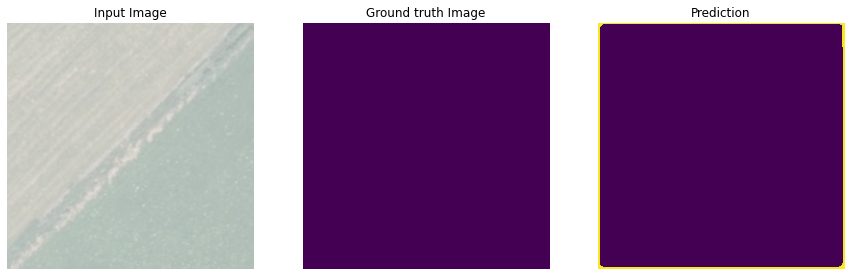

(16, 256, 256, 3) (16, 256, 256, 1)


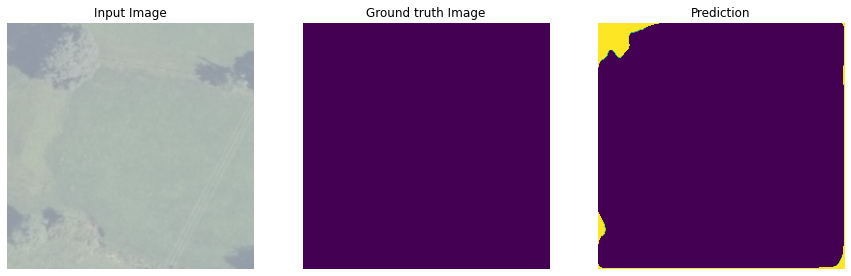

(16, 256, 256, 3) (16, 256, 256, 1)


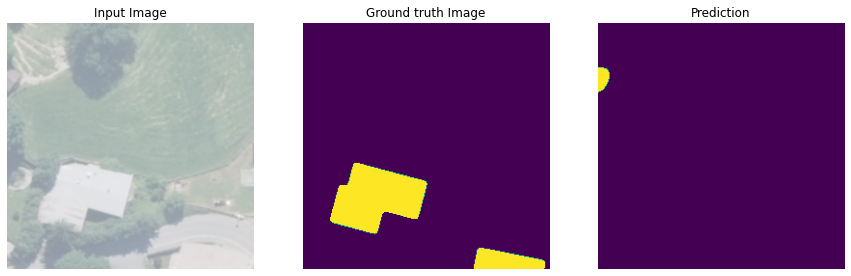

(16, 256, 256, 3) (16, 256, 256, 1)


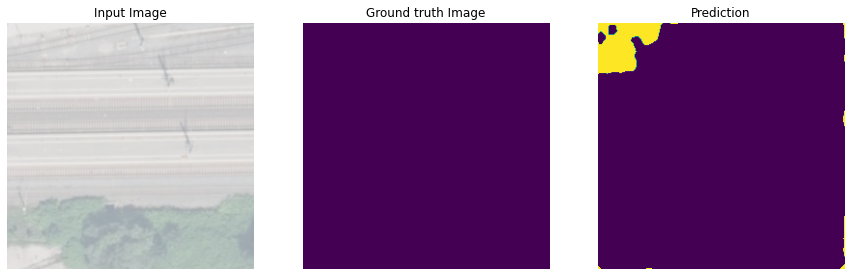

(16, 256, 256, 3) (16, 256, 256, 1)


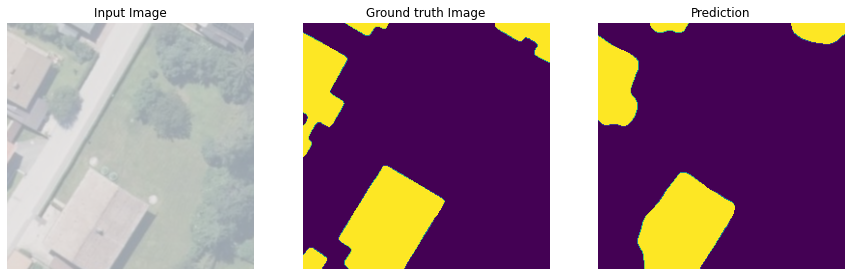

(16, 256, 256, 3) (16, 256, 256, 1)


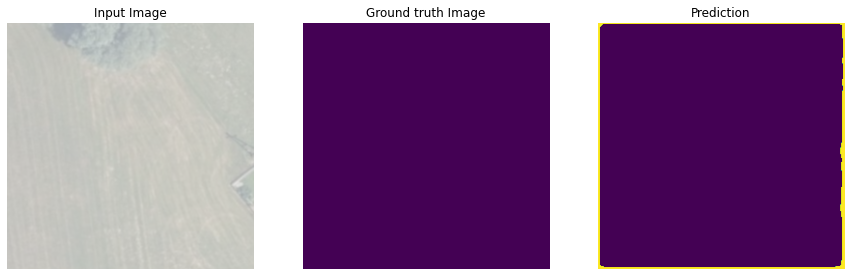

(16, 256, 256, 3) (16, 256, 256, 1)


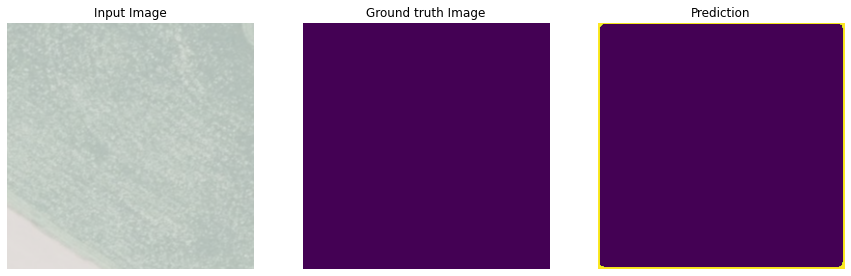

(16, 256, 256, 3) (16, 256, 256, 1)


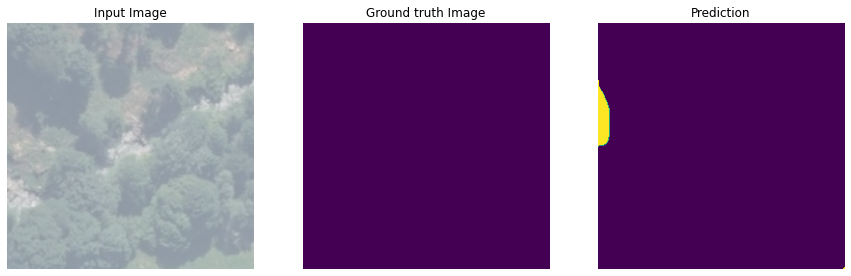

(16, 256, 256, 3) (16, 256, 256, 1)


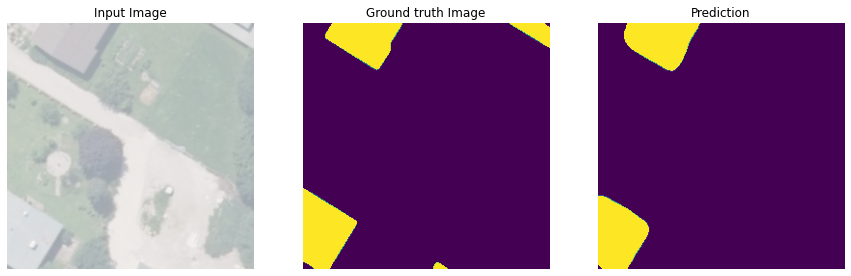

(16, 256, 256, 3) (16, 256, 256, 1)


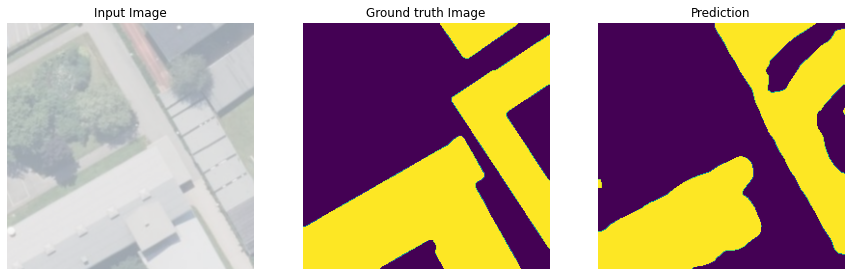

(16, 256, 256, 3) (16, 256, 256, 1)


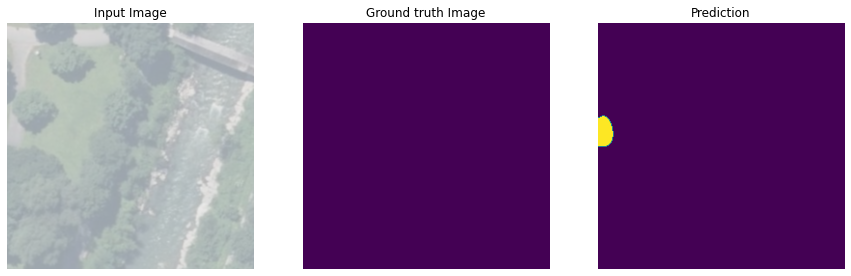

(16, 256, 256, 3) (16, 256, 256, 1)


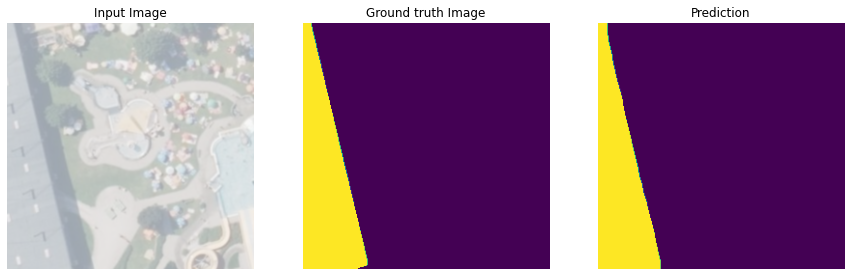

(16, 256, 256, 3) (16, 256, 256, 1)


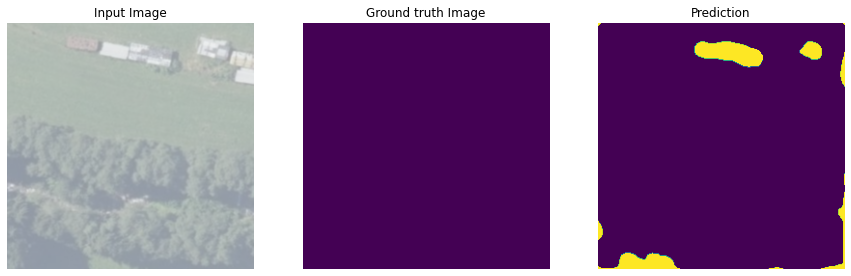

(16, 256, 256, 3) (16, 256, 256, 1)


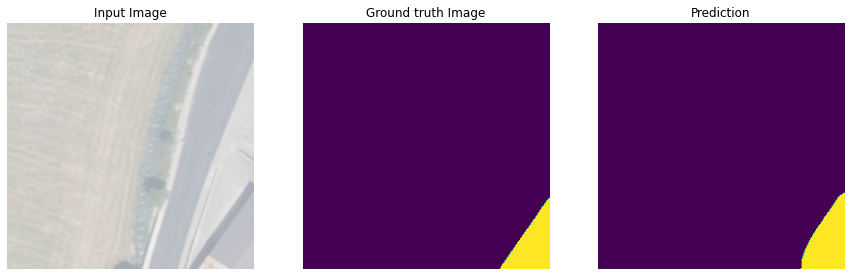

(16, 256, 256, 3) (16, 256, 256, 1)


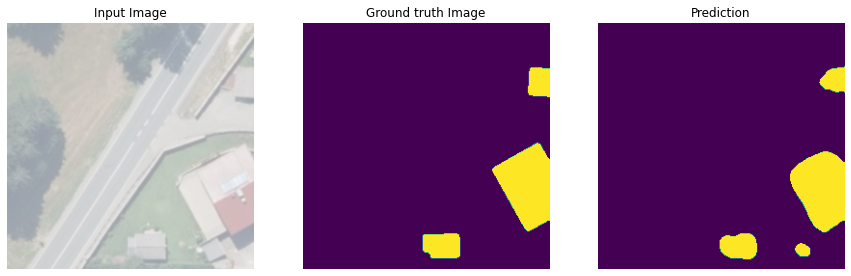

(16, 256, 256, 3) (16, 256, 256, 1)


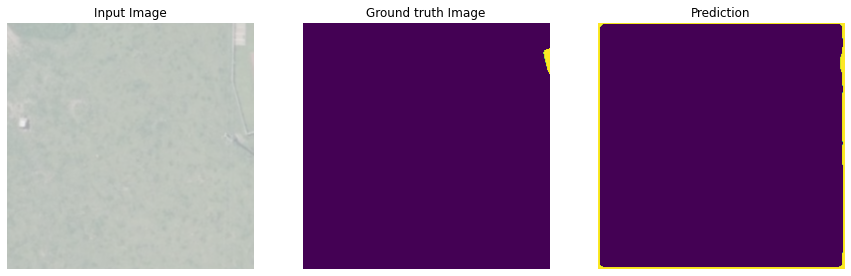

(16, 256, 256, 3) (16, 256, 256, 1)


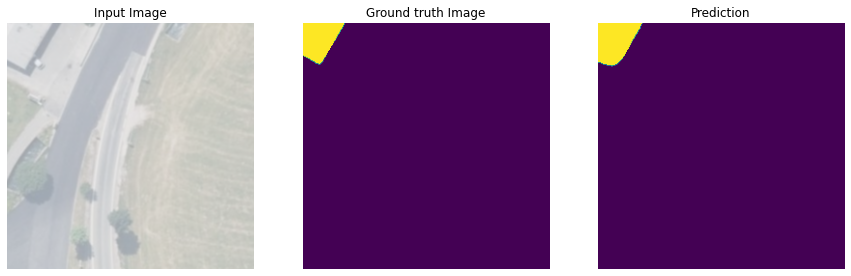

(16, 256, 256, 3) (16, 256, 256, 1)


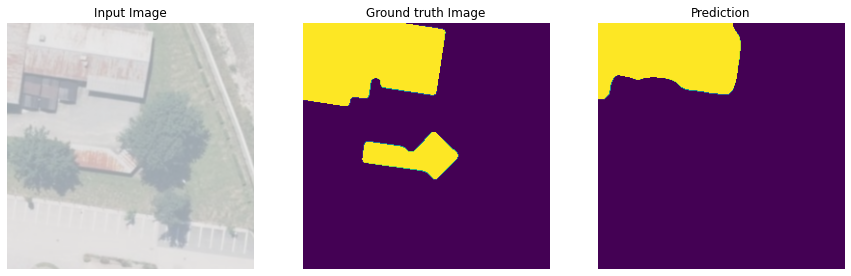

(16, 256, 256, 3) (16, 256, 256, 1)


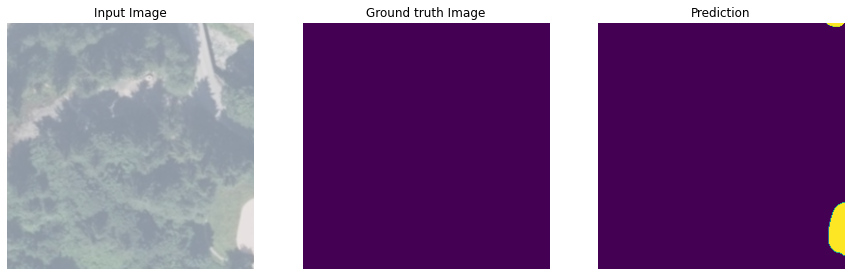

(16, 256, 256, 3) (16, 256, 256, 1)


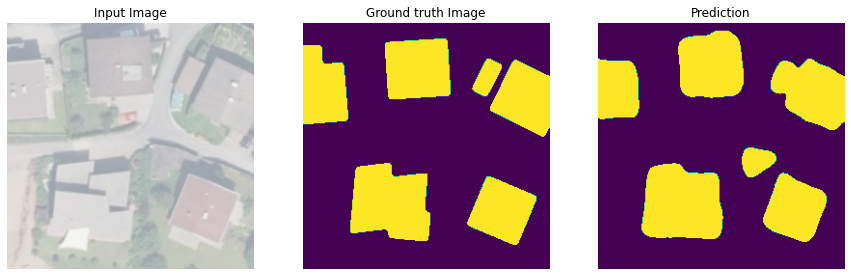

(16, 256, 256, 3) (16, 256, 256, 1)


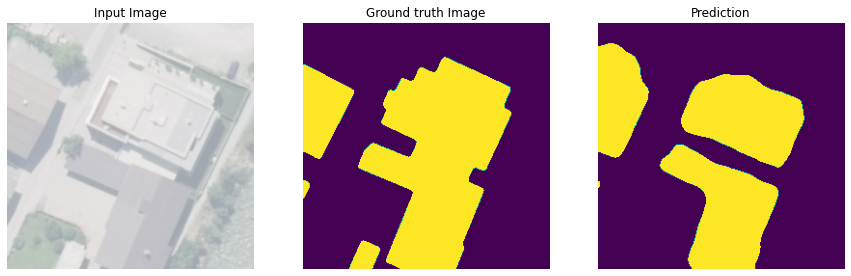

(16, 256, 256, 3) (16, 256, 256, 1)


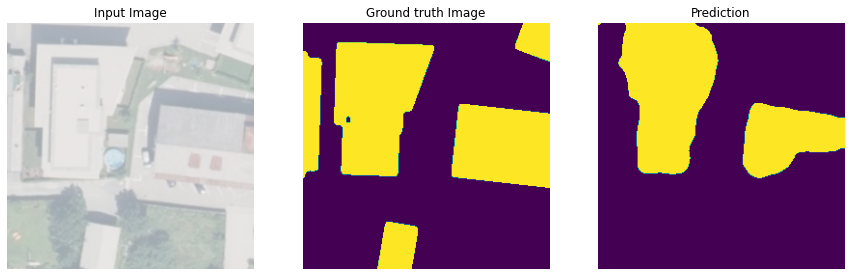

(16, 256, 256, 3) (16, 256, 256, 1)


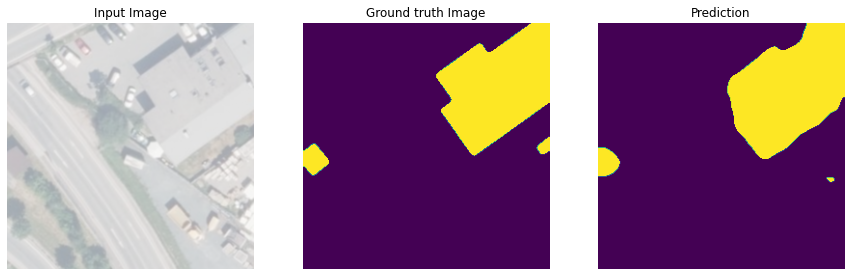

(16, 256, 256, 3) (16, 256, 256, 1)


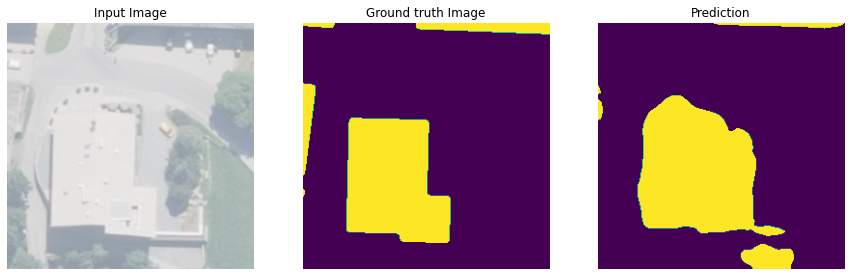

(16, 256, 256, 3) (16, 256, 256, 1)


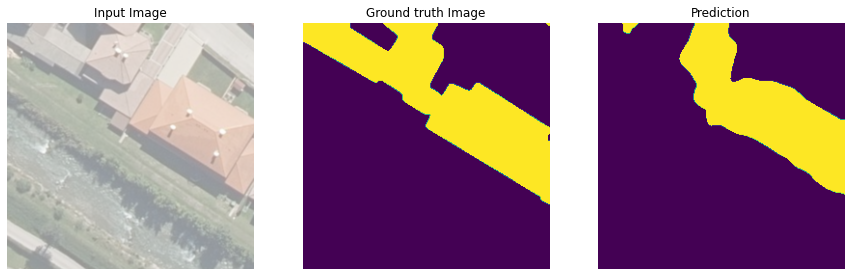

(16, 256, 256, 3) (16, 256, 256, 1)


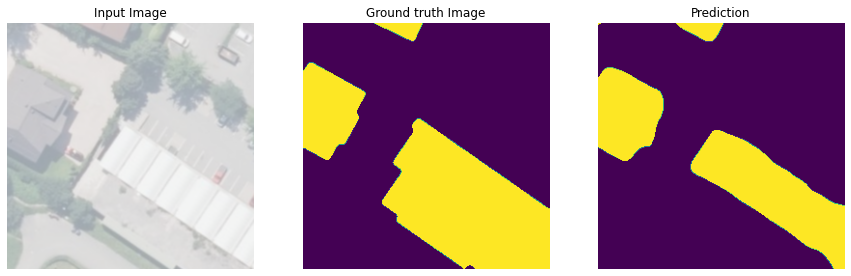

(16, 256, 256, 3) (16, 256, 256, 1)


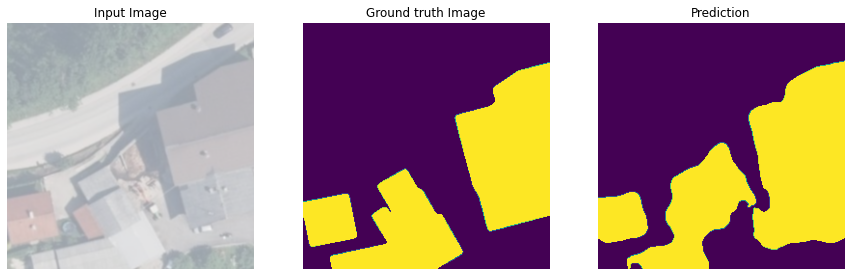

(16, 256, 256, 3) (16, 256, 256, 1)


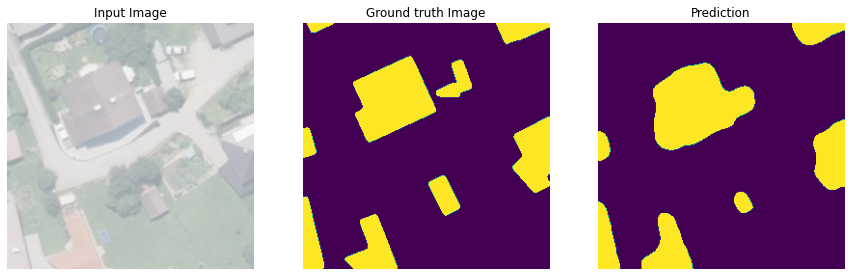

(16, 256, 256, 3) (16, 256, 256, 1)


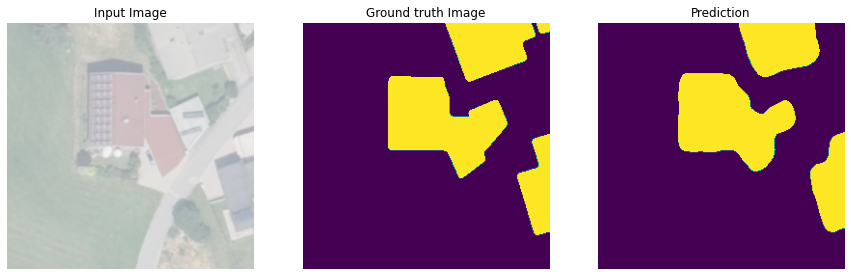

In [10]:
for SB, GT in test_dataset.take(30):
    prediction = model.predict(SB)
    plt.figure(figsize=(15,15))
    print(SB.shape, GT.shape)
    
    guass_img = gaussian_filter(prediction[0,:,:,:,], sigma =2)
    threshold =  find_threshold_otsu(guass_img)
    binary_prediction = binary(guass_img, threshold, max_value = 1)
    
    display_list=[SB[0,:,:,:,],GT[0,:,:,:,],binary_prediction]
    title = ['Input Image', 'Ground truth Image',"Prediction"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*.5+.5 )
        plt.axis('off')
    plt.show()